# Get statistics of the Loop Current from Sea Surface Height fields following: Leben 2005 - Altimeter-Derived Loop Current Metrics

0. TODO: add link to the python script to download every year of the dataset
1. Load 0.25° Absolute Dynamic Topography (ADT) in the Caribbean and GoM (from [Copernicus](http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047))
2. Calculate mean ADT in the region of the GoM deeper than 200m
3. Remove mean value from ADT value to eliminate thermal expansion
4. Extract and filter the 17-cm contour of the Loop Current
5. Find the maximum west longitude and north latitude coordinates to determine the extent of westward and northward penetration of the Loop Current.
6. Filter the signal to keep weekly variation
7. Generate a retracted variable 0 if ext_latitude < mean(extented_latitude) else 1
8. Output to csvfile

In [38]:
import os
import sys
import cmocean
import h5netcdf
from netCDF4 import Dataset
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import path
import numpy as np
import tabulate
import pandas as pd
import scipy.signal as signal
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy import linalg
from skimage import measure
from matplotlib.ticker import MultipleLocator, FuncFormatter
import datetime

# animation
from matplotlib import animation, rc
from IPython.display import HTML

sys.path.insert(0, os.path.expanduser('~/Dropbox/3. Post-Doc/pf-py'))
from maptools import gridplot, bathymetry, axis
from changeCoordinates import sph2xy, xy2sph, wrap_to_180

# constant
seconds_in_day = 60 * 60 * 24 # [s]

# add degree °W and °E and remove negative sign
def label_lon(x, pos):
    'The two args are the value and tick position'
    if x > 0:
        return '%d°E' % x
    else:
        return '%d°W' % -x

# add °N and °S and remove negative sign
def label_lat(x, pos):
    'The two args are the value and tick position'
    if x > 0:
        return '%d°N' % x
    else:
        return '%d°S' % -x

In [39]:
plot_lon = [-98, -78]
plot_lat = [18.125, 31]
ex, ey, ez = bathymetry.bathymetry_etopo(plot_lon, plot_lat)
eland = np.copy(ez)
eland[eland > 0] = 65.
skip = 1
elon = ex[::skip]
elat = ey[::skip]
eheight = ez[::skip, ::skip]
eland = eland[::skip, ::skip]

def cm2inch(value):
    return value/2.54

# 1/4 page figure = 95 mm x 115 mm
# Full page = 190 mm x 230 mm
fullsize = ((cm2inch(19.0), cm2inch(23.0)))
quartersize = ((cm2inch(9.5), cm2inch(11.5)))

# dictionnary to sort labels of special drifters in 
# order of their buoyancy
sort_labels = {
    "sargassum": 1,
    "cuboid": 2,
    "sphere": 3,
    "cube": 4,
}

# dictionnary to sort labels of group in order of buoyancy
sort_groups = {
    1: 0,
    3: 1,
    2: 2,
    5: 2,
    4: 3,
}

def gom_map(fig, ax, grid=None, value=None, cc=None):
    """
    :param fig:
    :param ax:
    :param cc:
    :param grid:
    :param value:
    :return:
    """
    if np.any(grid != None) and np.any(value != None):
        gridplot.quadfill(fig, ax, False, grid, coords, value, cc)

    # bathymetry
    ax.contour(elon, elat, eheight, [0], colors='black', linewidths=0.25)
    ax.contourf(elon, elat, eland, np.arange(0, 110, 10), cmap=cm.binary)
    ax.set_xlim(plot_lon)
    ax.set_ylim(plot_lat)
    axis.format(ax, 5, 5)

In [26]:
years = np.arange(1993,2020)

datafile = '~/Documents/data/gom-ssh/%d-01-ssh.nc' % years[0]
f = Dataset(os.path.expanduser(datafile))
with Dataset(os.path.expanduser(datafile), 'r') as f:
    lon = wrap_to_180(f['longitude'][...])
    lat = f['latitude'][...]
    
adt = np.empty((len(lon),len(lat),0))

for year in years:
    if year == 2019:
        month_range = np.arange(1,5)
    else:
        month_range = np.arange(1,13)
        
    for month in month_range:
        file = '~/Documents/data/gom-ssh/%d-%02d-ssh.nc' % (year, month)
        f = Dataset(os.path.expanduser(file))
        adti = np.moveaxis(f['adt'][...], [0,1,2], [2,1,0]) # [lon, lat, time]
        adt = np.ma.concatenate((adt, adti), axis=2)
        
base = datetime.datetime(1993,1,1)
numdays = len(adt[0,0,:])
date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]

### Remove daily average ADT over the GoM deepwater (>200m depth) from ADT to remove thermal expansion effects

In [40]:
# box for Caribbean and Atlantic ocean
gom_bnd = np.array([[-87.5, 21.15], [-84.15, 22.35], [-82.9, 22.9], [-81, 22.9], [-81, 27], [-82.5, 32.5], [-76.5, 32.5], [-76.5, 16.5], [-90, 16.5], [-87.5, 21.15]])
gom_path = path.Path(gom_bnd)

gom = np.full_like(adt[:,:,0], np.nan)

# probably can remove the loops here and do this one line contains_points and not masked!

for i in range(0,len(lon)):
    for j in range(0,len(lat)):
        if not np.ma.is_masked(gom[i,j]):
            gom[i,j] = not gom_path.contains_points(([[lon[i], lat[j]]]))

# this is not used for now but could be used to calculated flow rate
yuc = np.array([[-86.85, 21.5], [-84.25, 21.5]])
fls = np.array([[-81, 23], [-81, 25.2]])

In [41]:
# bathymetry data for the domain
depth = RegularGridInterpolator((elon, elat), np.moveaxis(ez, [0, 1], [1, 0]), method='linear', bounds_error=False, fill_value=np.nan)

# get a mask for deepwater of the GoM which is defined by Leben et al. by 200m+
gom_deep = np.copy(gom)
for i in range(0,len(lon)):
    for j in range(0,len(lat)):
        if depth([lon[i], lat[j]]) > -200:
            gom_deep[i,j] = False

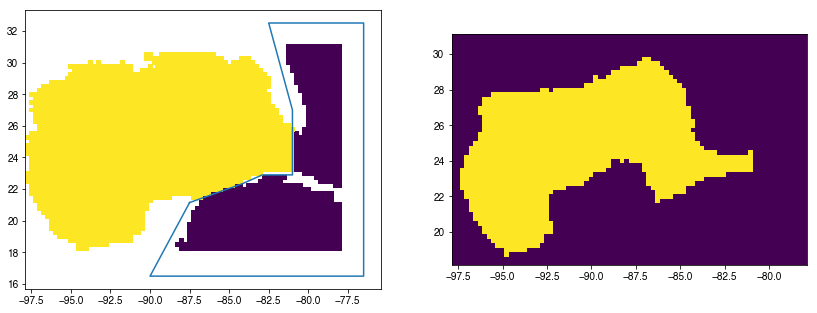

In [42]:
# get a mask for the data in the GoM
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1,2,1)
ax1.pcolor(lon, lat, gom.T)
ax1.plot(gom_path.vertices[:,0], gom_path.vertices[:,1])
ax1.set_aspect('equal')

ax2 = fig.add_subplot(1,2,2)
ax2.pcolor(lon, lat, gom_deep.T)
ax2.set_aspect('equal')

In [43]:
# calculate the mean value of adt in the deep GoM (deepter than 200m)
mean_adt = np.mean(adt[gom_deep == 1],0)
adt -= mean_adt

In [44]:
def filter_contour(cc):
    filter_gom(cc)
    filter_loop(cc)
    
def filter_loop(cc):
    "Remove contour that are eddies"
    for level in cc.collections:
        for kp, path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!
            verts = path.vertices  # (N,2)-shape array of contour line coordinates
            #print(kp)
            #print(verts[0])
            #print(verts[-1])
            if np.linalg.norm(verts[0]-verts[-1]) < 0.1:  # presence of a loop
                del (level.get_paths()[kp])
            # this removes little contour next to bnd in gom could be a problem..
            elif len(verts[:, 0]) < 25: 
                del (level.get_paths()[kp])

def filter_gom(cc):
    "Remove contour that are outside of the Gom"
    for level in cc.collections:
        for kp, path in reversed(list(enumerate(level.get_paths()))):  
            # small contour not in GOM
            verts = path.vertices
            if np.all(gom_path.contains_points(np.array((verts[:,0],verts[:,1])).T)):
                del (level.get_paths()[kp])

def loop_current_extent(cc):
    min_lon = 0
    max_lat = 0
    for level in cc.collections:
        for kp, path in list(enumerate(level.get_paths())):
            verts = path.vertices
            
            # points inside the gom and over 21.5°N to avoid always counting the Yucatan corner
            # around the location where the 17-cm contour start
            in_gom = ~gom_path.contains_points(np.array((verts[:,0],verts[:,1])).T)
            over_21 = verts[:,1] > 21.5
            conditions = np.logical_and(in_gom, over_21)
            
            # maximum extent
            #  --- VALIDATE THIS STEP TO FOLLOW LITTERATURE ---
            #index = np.argmax(verts[:, 1][conditions])
            #min_lon = min(min_lon, verts[:, 0][conditions][index])
            #max_lat = max(max_lat, verts[:, 1][conditions][index])
            
            min_lon = min(min_lon, np.min(verts[:, 0][conditions]))
            max_lat = max(max_lat, np.max(verts[:, 1][conditions]))
            
            
    return min_lon, max_lat


def change_units(cc):
    """skimage functions extracts the contour but the paths are image indices
    and not (lon, lat)"""
    flon = interp1d(np.arange(0,len(lon)), lon)
    flat = interp1d(np.arange(0,len(lat)), lat)
    for cci in cc:
        cci[:,0] = flon(cci[:,0])
        cci[:,1] = flat(cci[:,1])
    return cc


def filter_contour2(cc):
    cc = filter_gom2(cc)
    cc = filter_loop2(cc)
    return cc


def filter_loop2(cc):
    """Remove contour that are eddies"""
    for i in range(len(cc)-1, -1, -1):
        cci = cc[i]
        if np.linalg.norm(cci[0]-cci[-1]) < 0.5:  # presence of a loop
            del cc[i]
    return cc


def filter_gom2(cc):
    """Remove contour that are outside of the Gom"""
    for i in range(len(cc)-1, -1, -1):
        cci = cc[i]
        if np.all(gom_path.contains_points(np.array([cci[:,0],cci[:,1]]).T)): # carribbean or atlantic ocean
            del cc[i]
        elif np.all(cci[:,0] < -89): # contour in the western gom
            del cc[i]
        elif len(cci) < 25: # non-useful little contour 
            del cc[i]
    return cc


def loop_current_extent2(cc):
    min_lon = 0
    max_lat = 0
    for cci in cc:
        # points inside the gom and over 21.5°N to avoid always counting the Yucatan corner
        # around the location where the 17-cm contour start
        in_gom = ~gom_path.contains_points(np.array([cci[:,0], cci[:,1]]).T)
        over_21 = cci[:,1] > 21.5
        conditions = np.logical_and(in_gom, over_21)

        # maximum extent
        #  --- VALIDATE THIS STEP TO FOLLOW LITTERATURE ---
        #index = np.argmax(verts[:, 1][conditions])
        #min_lon = min(min_lon, verts[:, 0][conditions][index])
        #max_lat = max(max_lat, verts[:, 1][conditions][index])

        min_lon = min(min_lon, np.min(cci[:, 0][conditions]))
        max_lat = max(max_lat, np.max(cci[:, 1][conditions]))
            
    return min_lon, max_lat

In [45]:
date_list[day].strftime("%m/%d/%Y")

'10/18/2018'

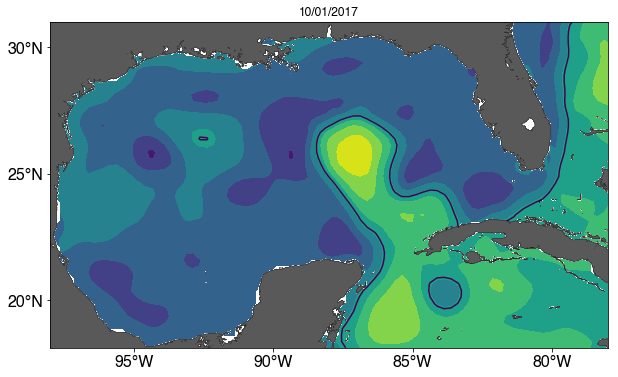

In [106]:
day = 9039  # October, 2017
#day = 9404 # October, 2018
#day = 9245  # April, 2018 Eddy Revelle first separation
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.contourf(lon, lat, adt[:,:,day].T)
cc = ax.contour(lon, lat, adt[:,:,day].T, [0.17])

gom_map(fig, ax)
axis.format(ax, 5, 5)
ax.tick_params(labelsize=16)

ax.set_title('%s' % date_list[day].strftime("%m/%d/%Y"))
fig.savefig('lc_ex.png', dpi=600)

In [47]:
'''
# this code runs 10x+ slower than using skimage contour extracts!
%%time

ext_lon = np.zeros(adt.shape[2])
ext_lat = np.zeros(adt.shape[2])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
for day in range(0, 100):
    ax.contourf(lon, lat, adt[:,:,day].T)
    cc = ax.contour(lon, lat, adt[:,:,day].T, [0.17])
    filter_contour(cc)
    ext_lon[day], ext_lat[day] = loop_current_extent(cc)
    plt.close()
''';

In [48]:
# Find contours of 17 cm
ext_lon = np.zeros(adt.shape[2])
ext_lat = np.zeros(adt.shape[2])
for day in range(0, adt.shape[2]):
    cc = measure.find_contours(adt[:,:,day], 0.17, fully_connected='low', positive_orientation='low')
    cc = change_units(cc)
    cc = filter_contour2(cc)
    ext_lon[day], ext_lat[day] = loop_current_extent2(cc)

In [49]:
ext_lat

array([25.72738494, 25.7574164 , 25.79099744, ..., 27.40679324,
       27.46260415, 27.51540532])

In [50]:
sum(ext_lat == 0)

0

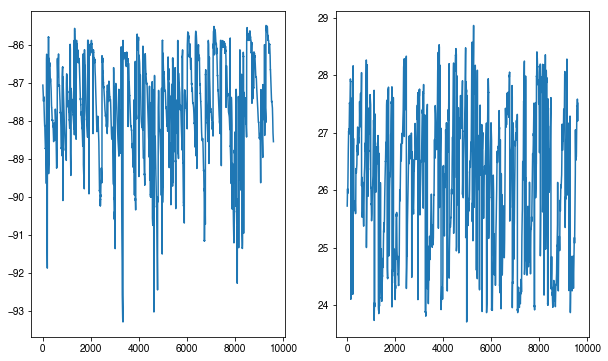

In [51]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(ext_lon)
ax2.plot(ext_lat)

In [52]:
Fs = 10.0 # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

In [53]:
def butterworth_filter(x, wn):
    """Second order Butterworth filter application on a daily time-series"""
    fs = 1 # one per day
    nyquist_freq = 0.5 * fs

    # For digital filters, Wn are in the same units as fs
    # normalized from 0 to 1, where 1 is the Nyquist frequency. (Wn is thus in half-cycles / sample.)
    wn /= nyquist_freq # Cutoff frequency normalized by nyquist
    b, a = signal.butter(2, wn, btype='lowpass', output='ba', fs=fs, analog=False)
    return signal.filtfilt(b, a, x)

In [54]:
# filtered data
ext_lon_filt = butterworth_filter(ext_lon, 1/7)
ext_lat_filt = butterworth_filter(ext_lat, 1/7)

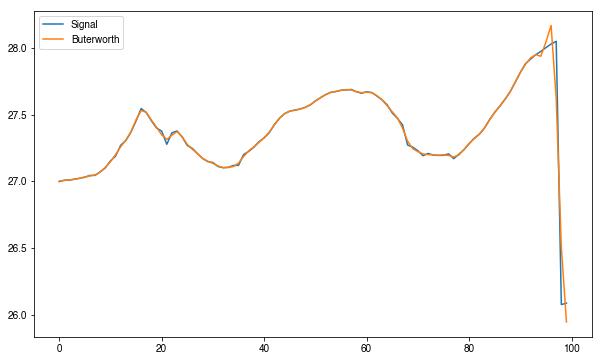

In [55]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)


plot_range = np.arange(500, 600)
ax1.plot(ext_lat[plot_range], label='Signal')
ax1.plot(ext_lat_filt[plot_range], label='Buterworth')
ax1.legend();

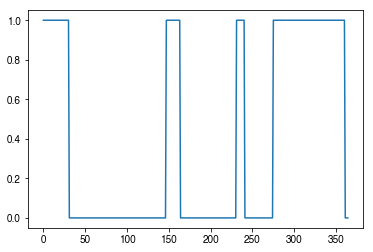

In [63]:
extended = ext_lat_filt > np.mean(ext_lat)
retracted = ext_lat_filt < np.mean(ext_lat)
plt.plot(retracted[:365])

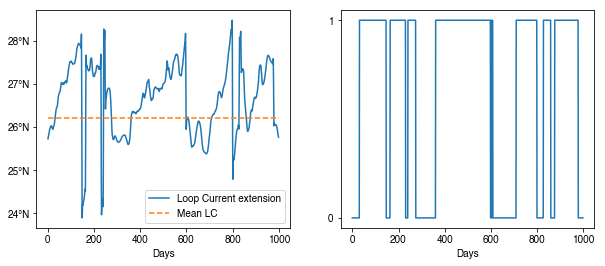

In [64]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

nb_days = 1000
ax1.plot(ext_lat_filt[:nb_days], label='Loop Current extension')
ax1.plot(np.arange(0,nb_days), np.ones_like(extended[:nb_days])*np.mean(ext_lat), linestyle='--', label='Mean LC')
ax1.legend(loc=0)
extended = ext_lat_filt > np.mean(ext_lat)
ax2.plot(extended[:nb_days])

ax1.set_xlabel('Days')
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_major_formatter(FuncFormatter(label_lat))

ax2.set_xlabel('Days')
ax2.yaxis.set_major_locator(MultipleLocator(1))
fig.savefig('lc_ext_timeseries.png', dpi=600)

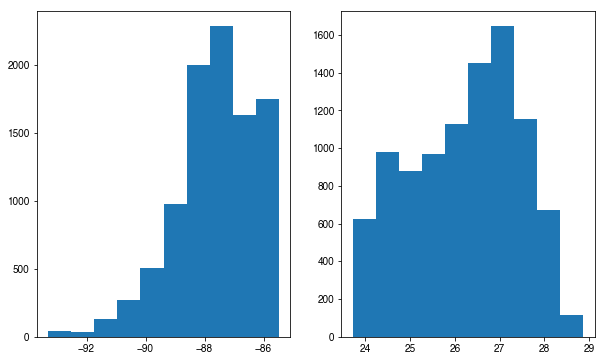

In [65]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(ext_lon);
ax2.hist(ext_lat);

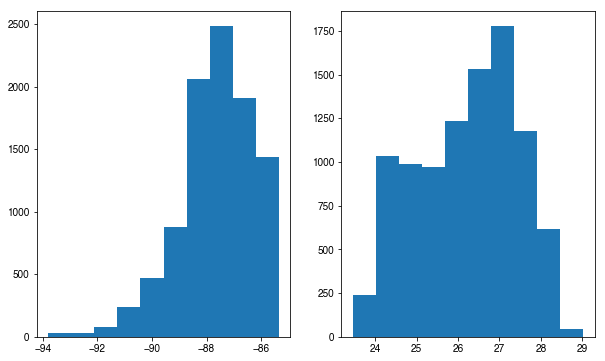

In [66]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.hist(ext_lon_filt);
ax2.hist(ext_lat_filt);

In [76]:
# save signal, filtered signal and retracted value in a csv format
datenum = np.arange(727930, 727930+len(adt[0,0,:]))
outdata = np.column_stack((datenum, ext_lon, ext_lon_filt, ext_lat, ext_lat_filt, retracted))
np.savetxt("loop_current_state.csv", outdata, header='datenum, ext_lon, ext_lon_filt, ext_lat, filt_ext_lat, retracted', delimiter=",", comments='#')

In [108]:
# Generate animation for the full dataset
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are animating three artists, the contour and 2 
# annotatons (title), in each frame
ims = []

ax.contour(elon, elat, eheight, [0], colors='black', linewidths=0.25)
ax.contourf(elon, elat, eland, np.arange(0, 110, 10), cmap=cm.binary)

for day in range(0, 365):#adt.shape[2]):
    im1 = ax.contourf(lon, lat, adt[:,:,day].T)
    im2 = ax.contour(lon, lat, adt[:,:,day].T, [0.17])
    filter_contour(im2)    
    add_arts1 = im1.collections
    add_arts2 = im2.collections
    

    
    ext_loni, ext_lati = loop_current_extent(im2)
    text = 'Loop current extends to %0.2f°W and %0.2f°N (day #%02d)' % (ext_loni, ext_lati, day)
    te = ax.text(0.5, 1.02, text, horizontalalignment='center', verticalalignment='center', 
                 transform=ax.transAxes, fontsize=13)
    ims.append(add_arts1 + add_arts2 + [te])
    
    axis.format(ax, 5, 5)
    ax.tick_params(labelsize=16)

anim = animation.ArtistAnimation(fig, ims, interval=70, repeat_delay=1000, blit=True)
plt.close()

In [109]:
HTML(anim.to_html5_video())

In [110]:
anim.save('lc.gif', writer='imagemagick', fps=60)